### FE-620 FINAL PROJECT: BINOMIAL PRICING MODEL FOR SPY OPTIONS

#### IMPORTS

In [2152]:
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import copy
import os

#### PARAMETERIZATION FUNCTIONS

In [2153]:
def _get_binom_rn_params(n : float, t : float, r : float, hvol : float, prec : int):
    # calc tree params
    dt = t/n
    u = np.exp(hvol*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt)-d)/(u-d)
    q = 1 - p
    # # print divider
    # print("-"*80) # # commented out for iterative calling # #
    # print params # # commented out for iterative calling # #
    # print((f"dt: {round(dt, 2)}  | u: {round(u, 2)}  |  d: {round(d, 2)}  |  p: {round(p, 2)}  |  q: {round(q, 2)}  |  hvol: {round(hvol, 2)}").center(80)) # 56 is len of divider
    # # print divider
    # print("-"*80) # # commented out for iterative calling # #
    return t, dt, u, d, p, q

In [2154]:
def _get_div_idx(div : dict, steps : int, maturity : float):
    if div is None:
        return None
    # # print dividends
    # print(f"dividends: {str(div)}".center(80)) # # commented out for iterative calling # #
    # get "todays" date - time 0
    start = list(div.keys())[0]
    # copy dict so dont change during iteration
    idxdiv = copy.deepcopy(div)
    # replace start date with index 0 for start date
    idxdiv[0] = idxdiv.pop(start)
    # calc time length of each step
    dt = maturity/steps
    # get index of each div date 
    for date in list(div.keys()): # use list() to avoid dict size change during iteration
        # skip start key/val pair
        if date != start:
            # calculate index aka days since start
            idx = round((np.busday_count(np.datetime64(start), np.datetime64(date))/252)/dt)
            # switch date with index
            idxdiv[idx] = idxdiv.pop(date)
    return idxdiv

# explanation of dividend index calculation for varied time steps:
# diff days / 252 = diff in years since start
# dt = (t in years) / steps = time of step in years
# diff in years / time of step in years = steps since start -> rounded = index of step


#### PRICING FUNCTIONS

In [2155]:
def _calc_maturity_value(stock : list, tree : list, s0 : float, k : float, n : int, t : float, u : float, d : float, prec : int, type : str, div : dict):
    # call div idx func if divs - will return div to model for subsequent backprop call
    idxdiv = _get_div_idx(div, n, t)
    # if idxdiv is not None: print(f"dividends @ indices: {idxdiv}".center(80))
    # # print divider
    # print("-"*80) # # commented out for iterative calling # #
    # print header for output
    # print("ADJUSTMENT & EXERCISE REPORT".center(80))
    # # print divider
    # print("-"*80) # # commented out for iterative calling # #
    # check if dividend paid at maturity by checking if # of total steps is in div dict
    if idxdiv is not None and n in list(idxdiv.keys()):
        # get div amount
        div_adj = idxdiv[n]
        # # print div adj
        # print(f"time {n}: dividend adjustment = {div_adj}") # # commented out for iterative calling # #
    else:
        div_adj = 0
    # check option type
    if type.lower() == "call":
        # iterate over rows (price/nodes) @ maturity
        for i in range(n, -1, -1):
            # calc stock price @ maturity considering potential dividend
            stock[n][i] = round((s0*(u**i)*(d**(n-i)))-div_adj, prec) # s = s0 x up % ^ # up moves x down % ^ # down moves - div adj
            # # print stock price before & after div adj 
            # if div_adj != 0: print(f"time {n}: before div adj @ ${stock[n][i]+div_adj} & after div adj @ ${stock[n][i]}") # # commented out for iterative calling # #
            # calc option price @ maturity considering potential dividend
            tree[n][i] = round(max(stock[n][i]-k, 0.0), prec) # max(s - d - k, 0)
    elif type.lower() == "put":
        # iterate over rows (price/nodes) @ maturity
        for i in range(n, -1, -1):
            # calc stock price @ maturity considering potential dividend
            stock[n][i] = round((s0*(u**i)*(d**(n-i)))-div_adj, prec) # s = s0 x up % ^ # up moves x down % ^ # down moves - div adj
            # # print stock price before & after div adj
            # if div_adj != 0: print(f"time {n}: before div adj @ ${stock[n][i]+div_adj} & after div adj @ ${stock[n][i]}") # # commented out for iterative calling # #
            # calc option price @ maturity considering potential dividend
            tree[n][i] = round(max(k-stock[n][i], 0.0), prec) # max(k - s, 0)
    else:
        raise ValueError("invalid option type - please enter 'call' or 'put'")
    return stock, tree, idxdiv
    

In [2156]:
def _back_prop(stock : list, tree : list, idxdiv : dict, s0 : float, k : float, n : int, dt : float, r : float, u : float, d : float, p : float, q : float, prec : int, type : str):
    # iterate over cols (time)
    for i in range(n-1, -1, -1):
        # dividend idxs have already been identified in the maturity calculation so just have to check for them
        # check if div paid at this time step
        if idxdiv is not None and i in list(idxdiv.keys()) and i != 0:
            # get div amount
            div_adj = idxdiv[i]
            # # print div adj # # commented out for iterative calling # #
            # print(f"time {i}: dividend adjustment of - ${div_adj}".center(80))
        else:
            div_adj = 0
        # iterate over rows (price/nodes)
        for j in range(i+1, -1, -1):
            # fill in stock price at node
            stock[i][j-1] = round((s0*(u**j)*(d**(i-j)))-div_adj, prec) # s = s0 x up % ^ # up moves x down % ^ # down moves
            # find option price at node by discounting expected value of option price at next (later) time step
            tree[i][j-1] = round(np.exp(-r*dt)*(p*tree[i+1][j]+q*tree[i+1][j-1]), prec)
            if type.lower() == "call":
                # check exercise for call (option price vs intrinsic value) 
                # if max(tree[i][j-1], (stock[i][j-1] - k)) == (stock[i][j-1] - k): # # commented out for iterative calling # #
                #     print(f"time {i}: call exercised @ price ${stock[i][j-1]}".center(80))
                tree[i][j-1] = round(max(tree[i][j-1], (stock[i][j-1] - k)), 2) # max(s - k, 0)
            else:
                # check exercise for put (option price vs intrinsic value)
                # if max(tree[i][j-1], (k - stock[i][j-1])) == (stock[i][j-1] - k): # # commented out for iterative calling # #
                #     print(f"time {i}: put exercised @ price ${stock[i][j-1]}".center(80))
                tree[i][j-1] = round(max(tree[i][j-1], k - stock[i][j-1]), 2) # max(k - s, 0)
    return stock, tree

#### PRINTING FUNCTIONS

In [2157]:
def _print_model(type : str):
    # print divider
    print("-"*80)
    # print model
    print((f"AMERICAN {type.upper()} OPTION - RISK-NEUTRAL BINOMIAL PRICING MODEL").center(80)) # 56 is len of divider

In [2158]:
def _print_stock(stock : list):
    # print divider
    print("-"*80)
    # print header
    print("STOCK PRICE TREE".center(80))
    # print divider
    print("-"*80)
    # print price
    for time, prices in enumerate(stock, 0):
        centered = str(prices).center(65) # 65 is len of divider after time #:
        print(f"time {time}: {centered}")

In [2159]:
def _print_tree(tree : list, type : str):
    # print divider
    print("-"*80)
    # print header
    print(f"{type.upper()} OPTION PRICE TREE".center(80))
    # print divider
    print("-"*80)
    # print tree
    for time, branch in enumerate(tree, 0):
        # print centered row
        centered = str(branch).center(65) # 65 is len of divider after time #:
        print(f"time {time}: {centered}")
    # print divider
    print("-"*80)

DOWNLOAD DATA

In [2160]:
def _get_hdata(ticker : str, hist : str, end : str):
    # check if data is already downloaded
    path = '../csvs/spy_historical.csv'
    if os.path.isfile(path):
        df = pd.read_csv(path)
    # otherwise download data
    else:
        # download data
        df = yf.download('SPY', start=hist, end=end)
        # save data
        df.to_csv(path, header=True)
    # set date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # get adj close & convert index
    df = df[['Date', 'Adj Close']].rename(columns={'Adj Close':'spy', 'Date':'date'}).set_index('date')
    return df

#### HISTORICAL VOLATILITY FUNCTION

In [2161]:
def _get_hvol(df, hist : str, start : str, prec : int):
    # convert dates to datetime
    hist, start = pd.to_datetime(hist), pd.to_datetime(start)
    # calc historical volatility for window & annualize
    return ((df['spy'].pct_change().loc[hist:start]).dropna().std()*np.sqrt(252)).round(prec)

#### BINOMIAL PRICING MODEL FOR AMERICAN OPTION USING RISK NEUTRAL PROBABILITY

In [2162]:
def binom_rn_pricer(s0 : float, k : float, n : int, t : float, r : float, hvol : float, prec : int, type : str, div : dict):
    """
    s0: initial stock price
    k: strike price
    n: number of steps
    t: time to maturity per annum
    r: risk-free rate
    hvol: historical volatility - window size = maturity of rfr
    maturity: maturity of rate used (e.g, 1-month = 1, 3-month = 3, 6-month = 6, 1-year = 12)
    type: option type (call or put)
    div: dividend dictionary {start date : pricing date, div1 date : div1 #, div2 date : div2 #, ...}
    """
    # # print model # # commented out for iterative calling # #
    # _print_model(type)
    # get adjusted & calculated params
    t, dt, u, d, p, q = _get_binom_rn_params(n, t, r, hvol, prec)
    # initialize option tree
    tree = [[0]*(i+1) for i in range(n+1)]
    # initialize stock tree
    stock = [[0]*(i+1) for i in range(n+1)]
    # calc option prices at maturity
    stock, tree, idxdiv = _calc_maturity_value(stock, tree, s0, k, n, t, u, d, prec, type, div)
    # backpropagate
    stock, tree = _back_prop(stock, tree, idxdiv, s0, k, n, dt, r, u, d, p, q, prec, type)
    # # print option tree 
    # _print_tree(tree, type) # # commented out for iterative calling # #
    # # print stock price tree
    # _print_stock(stock) # # commented out for iterative calling # #
    # return price and df
    return tree[0][0], stock[0][0], tree, stock

#### PRICING TEST

THEORETICAL DUMMY DATA

In [2163]:
s0 = 100 # market price as of 6/1/23
k = 101 # call strike
n = 3 # if daily -> biz days to expiration (6/1/23 - 11/17/23) = 122
t = 6/12 # tmt per annum
r = .05 # 5% per annum
hvol = .25 # 10% per annum
prec = 2 # precision
type = "call" # option type
div = None # dividend yield

In [2164]:
optprice, stockprice, tree, stock = binom_rn_pricer(s0=s0, k=k, n=n, t=t, r=r, hvol=hvol, prec=prec, type=type, div=div)
# print option tree
_print_tree(tree, type)
# print stock price tree
_print_stock(stock)

--------------------------------------------------------------------------------
                             CALL OPTION PRICE TREE                             
--------------------------------------------------------------------------------
time 0:                               [9.52]                             
time 1:                           [11.07, 8.04]                          
time 2:                        [0.0, 21.65, 16.73]                       
time 3:                      [0.0, 0.0, 9.75, 34.82]                     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                STOCK PRICE TREE                                
--------------------------------------------------------------------------------
time 0:                              [100.0]                             
time 1:                           [110.75, 90.3]               

MARKET-LIKE DUMMY DATA

In [2165]:
# date params
hist = '2022-06-01' # 1 year of historical data
start = '2023-06-01' # observation date (i.e, t = 0)
end = '2023-11-17' # expiration date (i.e, t = n)
# contract params
type = "call" # option type
tdays = np.busday_count(np.datetime64(start), np.datetime64(end))
t = tdays / 252 # tmt per annum
prec = 2 # precision
s0 = 421.82 # market price as of 6/1/23
k = 455 # strike
n = 6 # number of steps
# market params
r = .0517 # feed in appropriate rate
histdf = _get_hdata('SPY', hist, end) # get historical data
hvol = _get_hvol(histdf, hist, start, prec) # get historical volatility
div = {start : 0, "2023-06-16" : 1.64, "2023-09-15" : 1.58} # use ex-dividend dates

In [2166]:
optprice, stockprice, tree, stock = binom_rn_pricer(s0=s0, k=k, n=n, t=t, r=r, hvol=hvol, prec=prec, type=type, div=div)
# print option tree
_print_tree(tree, type)
# print stock price tree
_print_stock(stock)

--------------------------------------------------------------------------------
                             CALL OPTION PRICE TREE                             
--------------------------------------------------------------------------------
time 0:                               [14.4]                             
time 1:                           [21.15, 7.21]                          
time 2:                         [6.82, 34.54, 7.7]                       
time 3:                     [0.0, 13.17, 54.54, 16.1]                    
time 4:                  [0.0, 0.0, 25.43, 81.84, 33.69]                 
time 5:               [0.0, 0.0, 0.0, 49.11, 112.71, 70.48]              
time 6:             [0.0, 0.0, 0.0, 0.0, 20.04, 79.97, 147.46]           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                STOCK PRICE TREE                             

PRICE @ T=0 WITH DAILY STEPS

In [2167]:
optprice, stockprice, tree, stock = binom_rn_pricer(s0=s0, k=k, n=121, t=t, r=r, hvol=hvol, prec=prec, type=type, div=div)
# print option tree
_print_tree(tree, type)
# print stock price tree
_print_stock(stock)

--------------------------------------------------------------------------------
                             CALL OPTION PRICE TREE                             
--------------------------------------------------------------------------------
time 0:                              [15.49]                             
time 1:                           [17.64, 13.31]                         
time 2:                       [15.24, 20.01, 11.36]                      
time 3:                    [13.07, 17.37, 22.62, 9.63]                   
time 4:                 [11.13, 14.98, 19.73, 25.47, 8.1]                
time 5:              [9.41, 12.82, 17.1, 22.33, 28.57, 6.76]             
time 6:           [7.9, 10.9, 14.72, 19.45, 25.17, 31.93, 5.61]          
time 7:        [6.59, 9.2, 12.58, 16.83, 22.03, 28.26, 35.55, 4.62]      
time 8:    [5.45, 7.71, 10.67, 14.46, 19.16, 24.86, 31.61, 39.43, 3.78]  
time 9: [4.48, 6.41, 8.99, 12.33, 16.55, 21.73, 27.94, 35.22, 43.58, 3.06]
time 10: [3.65, 

#### READ & PULL DATA

In [2168]:
call = pd.read_csv('../csvs/spycall.csv')
put = pd.read_csv('../csvs/spyput.csv')

In [2169]:
call['date'] = pd.to_datetime(call['date'], format='%m/%d/%y')
put['date'] = pd.to_datetime(put['date'], format='%m/%d/%y')
call.set_index('date', inplace=True)
put.set_index('date', inplace=True)

### SENSITIVITY ANALYSIS

STEPS

In [2170]:
def _pop_varied_steps_prices(df, steps : [int], s0 : float, k : float, tmt : float, rate : float, hvol : float, prec : prec, type : str, div : dict, date):
    # convert date to datetime
    date = pd.to_datetime(date)
    # iterate over steps
    for step in steps:
        # calc price
        optprice, stockprice, tree, stock = binom_rn_pricer(s0=s0, k=k, n=step, t=tmt, r=rate, hvol=hvol, prec=prec, type=type, div=div)
        # add to df
        df.loc[date, f'{step}price'] = optprice

RATES

In [2171]:
# def get_rates(df, ratecol : str):
#     rates = []
#     # get stats
#     result = df[ratecol].describe()
#     # get testing rates
#     for stat, value in result.items():
#         # add all stats except count, std, & max
#         if stat == 'count' or stat == 'std' or stat == 'max':
#             continue
#         rates.append(round(value, prec))
#     # return rates
#     return rates

# get_rates(call, 'sofr12m')

In [2172]:
def _pop_varied_rates_prices(df, ratecols : [str], s0 : float, k : float, n : int, tmt : float, hvol : float, prec : int, type : str, dic : dict, date):
    # convert date to datetime
    date = pd.to_datetime(date)
    for ratecol in ratecols:
        # get rates
        rate = np.mean(df[ratecol])/100
        # calc price
        optprice, stockprice, tree, stock = binom_rn_pricer(s0=s0, k=k, n=n, t=tmt, r=rate, hvol=hvol, prec=prec, type=type, div=div)
        # add price to df
        df.loc[date, f'{ratecol}price'] = optprice


HISTORICAL VOL TIME WINDOWS & IV

In [2173]:
def _get_vol_dates(hist : str, start : str):
    # get last 6 months, last 3 months, and last 1 month
    hvol6 = np.busday_offset(hist, 6*21, roll='forward') # forward = next biz days for non-biz day calc
    hvol3 = np.busday_offset(hist, 9*21, roll='forward')
    hvol1 = np.busday_offset(hist, 11*21, roll='forward')
    # swith to datetime for string conversion
    hvol6 = hvol6.astype(datetime)
    hvol3 = hvol3.astype(datetime)
    hvol1 = hvol1.astype(datetime)
    # add string versions to dict
    vols = {'hvol6' : hvol6.strftime('%Y-%m-%d'), 'hvol3' : hvol3.strftime('%Y-%m-%d'), 'hvol1' : hvol1.strftime('%Y-%m-%d'), 'ivol' : start}
    return vols
print(_get_vol_dates(hist, start))

{'hvol6': '2022-11-24', 'hvol3': '2023-02-21', 'hvol1': '2023-04-20', 'ivol': '2023-06-01'}


POPULATE THE DF W/ PRICES FROM VARIED PARAMS

In [2174]:
def _pop_varied_vol_prices(df, hist : str, start : str, s0 : float, k : float, tmt : float, rate : float, prec : int, type : str, div : dict, date):
    # for appending to df
    date = pd.to_datetime(date)
    # get hvol
    hvols = _get_hvol_dates(hist, start)
    for volw, dates in hvols.items():
        # convert date to datetime for indexing
        dtdate = pd.to_datetime(dates)
        # if using ivol, pull from observation day
        if volw == 'ivol':
            vol = df[dates]['iv']
        else:    
            # get hvol for date window
            vol = _get_hvol(histdf, dates, start, prec)
        # price
        optprice, stockprice, tree, stock = binom_rn_pricer(s0=s0, k=k, n=n, t=tmt, r=rate, hvol=vol, prec=prec, type=type, div=div)
        # add price to df
        df.loc[date, f'{volw}price'] = optprice

PRICE TREE PARAMETERS USING HISTORICAL CALIBRATION

In [2175]:
def _calculate_up_down_params(df):
    # get returns
    returns = df['spy'].pct_change().dropna()
    # get up & down moves
    up_moves = returns[returns > 0]
    down_moves = returns[returns < 0]
    # calc params
    avg_up = up_moves.mean()
    avg_down = down_moves.mean()

    p_up = len(up_moves) / len(returns)
    p_down = len(down_moves) / len(returns)

    return avg_up, avg_down, p_up, p_down


ITERATE OVER TIME FUNCTION

In [2176]:
def _pop_price_over_time(calldf, putdf, s0 : float, k : float, n : int, r : float, hvol : float, prec : int, div : dict, ratecols : [str], steps : [int], hist : str, start : str, end : str):
    for idxdate in calldf.index:
        datestr = idxdate.strftime('%Y-%m-%d')
        # stop pricing dat b4 end date
        if datestr == end:
            break
        # get time to maturity
        bizdays = np.busday_count(np.datetime64(datestr), np.datetime64(end))
        tmt = bizdays / 252
        # fill in base price
        optprice, _, _, _ = binom_rn_pricer(s0=s0, k=k, n=n, t=tmt, r=rate, hvol=hvol, prec=prec, type="call", div=div)
        calldf.loc[idxdate, 'baseprice'] = optprice
        optprice, _, _, _ = binom_rn_pricer(s0=s0, k=k, n=n, t=tmt, r=rate, hvol=hvol, prec=prec, type="put", div=div)
        putdf.loc[idxdate, 'baseprice'] = optprice

        # fill in varied steps prices
        _pop_varied_steps_prices(calldf, steps, s0, k, tmt, r, hvol, prec, "call", div, datestr)
        _pop_varied_steps_prices(putdf, steps, s0, k, tmt, r, hvol, prec, "put", div, datestr)
        # fill in varied rates prices
        _pop_varied_rates_prices(calldf, ratecols, s0, k, n, tmt, hvol, prec, "call", div, datestr)
        _pop_varied_rates_prices(putdf, ratecols, s0, k, n, tmt, hvol, prec, "put", div, datestr)
        # fill in historical vol & ivol varied prices
        _pop_varied_vol_prices(calldf, hist, start, s0, k, tmt, r, prec, "call", div, datestr)
        _pop_varied_vol_prices(putdf, hist, start, s0, k, tmt, r, prec, "put", div, datestr)
        print(f'{datestr} complete')
    return calldf, putdf


### RUN SENSITIVITY ANALYSIS

PARAMS SPECIFIED FOR RUNS WHERE ALL OTHER HELD CONSTANT

In [2177]:
# time params
hist = '2022-06-01' # 1 year of historical data
t0 = '2023-06-01' # observation date (i.e, t = 0)
end = '2023-11-17' # expiration date (i.e, t = n)
# market params
rate = call['sofr6m'].loc[datetime(2023, 6, 1, 0, 0)]/100  # get t = 0 rate for 6m
histdf = _get_hdata('SPY', hist, end) # get historical data
hvol = _get_hvol(histdf, '2022-11-24', t0, prec) # get 6m historical volatility
div = {start : 0, "2023-06-16" : 1.64, "2023-09-15" : 1.58} # use ex-dividend dates
# contract params
type = "call" # option type
tdays = np.busday_count(np.datetime64(t0), np.datetime64(end))
t = tdays / 252 # tmt per annum
s0 = 421.82 # market price as of 6/1/23
k = 455 # strike
n = 50 # steps
prec = 2 # precision

VARIED PARAMS

In [2178]:
steps = [5, 10, 50, 100, 121]
ratecols = ['sofr12m', 'sofr6m', 'sofr3m', 'sofr1m']

In [2179]:
call, put = _pop_price_over_time(call, put, s0, k, n, rate, hvol, prec, div, ratecols, steps, hist, t0, end)

2023-06-01 complete
2023-06-02 complete
2023-06-05 complete
2023-06-06 complete
2023-06-07 complete
2023-06-08 complete
2023-06-09 complete
2023-06-12 complete
2023-06-13 complete
2023-06-14 complete
2023-06-15 complete
2023-06-16 complete
2023-06-20 complete
2023-06-21 complete
2023-06-22 complete
2023-06-23 complete
2023-06-26 complete
2023-06-27 complete
2023-06-28 complete
2023-06-29 complete
2023-06-30 complete
2023-07-03 complete
2023-07-05 complete
2023-07-06 complete
2023-07-07 complete
2023-07-10 complete
2023-07-11 complete
2023-07-12 complete
2023-07-13 complete
2023-07-14 complete
2023-07-17 complete
2023-07-18 complete
2023-07-19 complete
2023-07-20 complete
2023-07-21 complete
2023-07-24 complete
2023-07-25 complete
2023-07-26 complete
2023-07-27 complete
2023-07-28 complete
2023-07-31 complete
2023-08-01 complete
2023-08-02 complete
2023-08-03 complete
2023-08-04 complete
2023-08-07 complete
2023-08-08 complete
2023-08-09 complete
2023-08-10 complete
2023-08-11 complete


In [2180]:
call.head()

,call,spy,iv,sofr1m,sofr1m50,sofr3m,sofr3m50,sofr3m200,sofr6m,sofr6m50,...,50price,100price,121price,sofr12mprice,sofr6mprice,sofr3mprice,sofr1mprice,hvol6price,hvol3price,hvol1price
date,,,,,,,,,,,,,,,,,,,,,
2023-06-01,5.46,421.82,12.576,5.17424,4.97660,5.27638,5.04878,4.4049,5.28528,5.02599,...,9.88,10.05,10.12,9.93,9.96,9.93,9.87,9.88,8.81,7.85
2023-06-02,7.45,427.92,12.570,5.14067,4.98357,5.23034,5.05543,4.4174,5.24547,5.03324,...,9.77,9.95,10.01,9.83,9.87,9.83,9.77,9.77,8.73,7.79
2023-06-05,7.67,427.10,12.515,5.15002,4.99045,5.25323,5.06296,4.4300,5.28773,5.04310,...,9.68,9.84,9.93,9.71,9.77,9.71,9.68,9.68,8.64,7.69
2023-06-06,6.64,428.03,12.160,5.13842,4.99740,5.23884,5.07160,4.4424,5.27695,5.05544,...,9.56,9.75,9.82,9.59,9.65,9.59,9.56,9.56,8.57,7.61
2023-06-07,6.64,426.55,11.923,5.13117,5.00385,5.23808,5.07854,4.4546,5.27788,5.06426,...,9.46,9.63,9.72,9.50,9.53,9.51,9.46,9.46,8.49,7.52


In [2181]:
call['error'] = call['baseprice'] - call['call']
put['error'] = put['baseprice'] - put['put']

In [2182]:
call.to_csv('../csvs/spycall_priced.csv', index=False)
put.to_csv('../csvs/spyput_priced.csv', index=False)

- check pricing model (iterate through each day from t=1 to t=T pricing using that day's tmt & s0 (feed in daily rate but run on different sofrs] to see how tmt & rate affects accuracy)
- plot both model's stock prices vs market, model's option prices vs market, 
- run sensitivty analysis and save results for graphs

GRAPHING FUNCTION

In [2183]:
def plot_xy(x, y, title, x_label, y_label, legend_label=None):
    color_rgb = (128, 0, 0)
    color_normalized = tuple(c / 255 for c in color_rgb)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, linestyle='-', color=color_normalized, label=legend_label)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    
    if legend_label:
        plt.legend()

    plt.show()

### BASE PRICING ALGO PLOTS

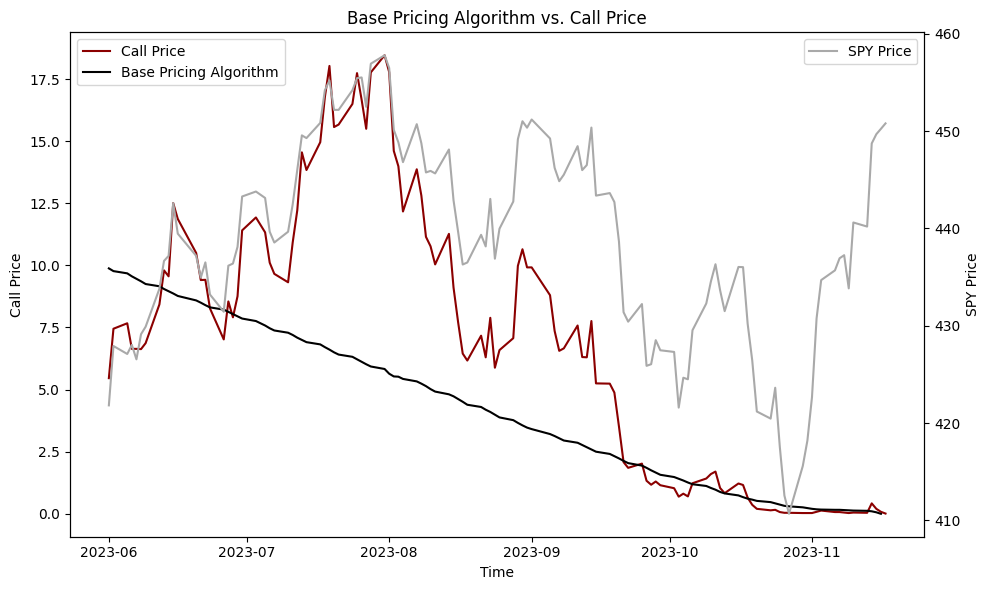

In [2185]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Call Price', color='black')
ax1.plot(call['call'], color='darkred', label='Call Price')
ax1.plot(call['baseprice'], color='black', label='Base Pricing Algorithm')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')
ax2.plot(call['spy'], color='darkgrey', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Base Pricing Algorithm vs. Call Price')
fig.tight_layout()  
plt.show()


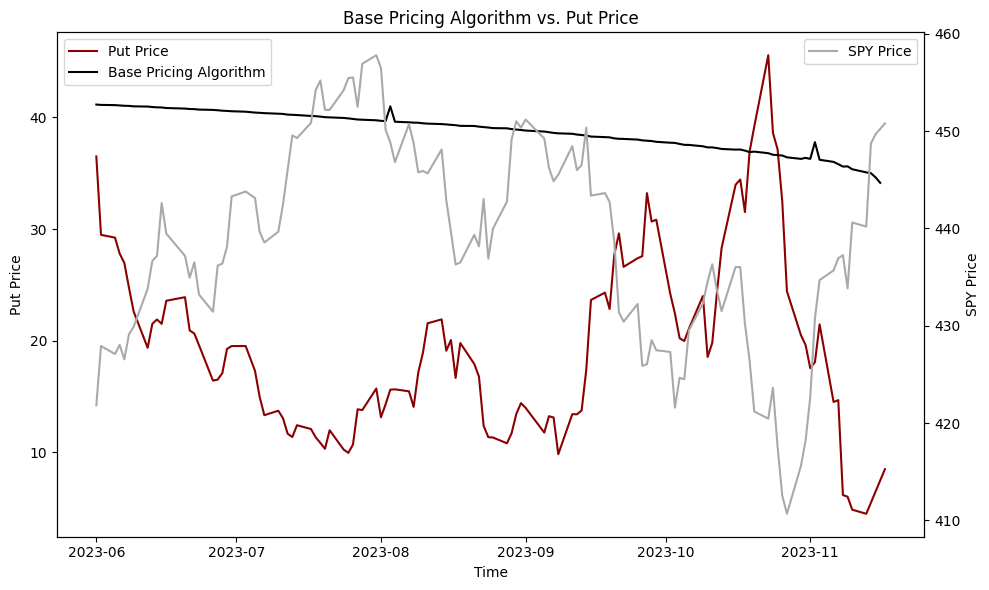

In [2186]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Put Price', color='black')
ax1.plot(put['put'], color='darkred', label='Put Price')
ax1.plot(put['baseprice'], color='black', label='Base Pricing Algorithm')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')
ax2.plot(put['spy'], color='darkgrey', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Base Pricing Algorithm vs. Put Price')
fig.tight_layout()  
plt.show()

### VARYING STEPS PLOTS

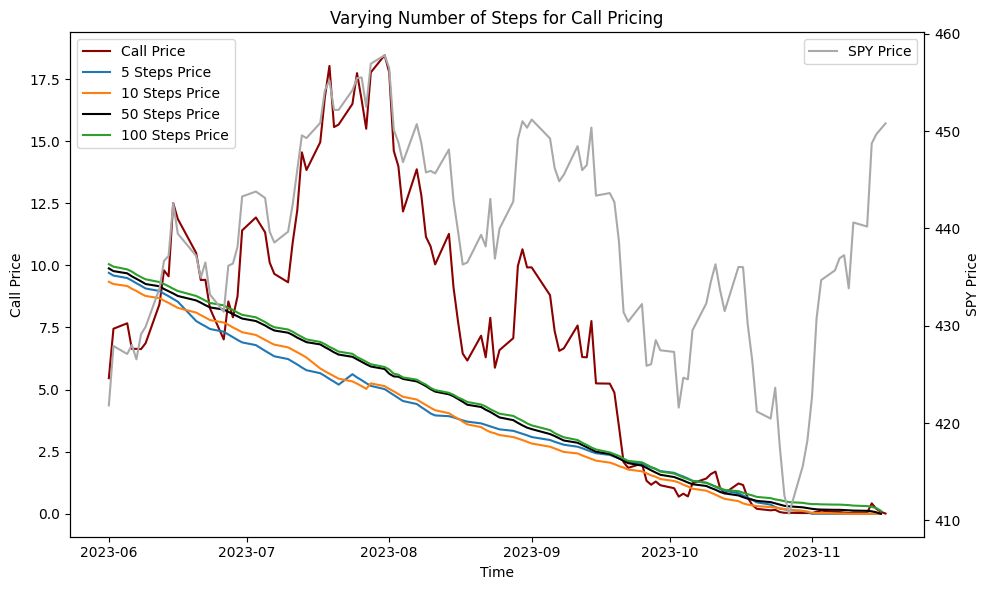

In [2187]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Call Price', color='black')
ax1.plot(call['call'], color='darkred', label='Call Price')
ax1.plot(call['5price'], label='5 Steps Price')
ax1.plot(call['10price'], label='10 Steps Price')
ax1.plot(call['50price'], color='black', label='50 Steps Price')
ax1.plot(call['100price'], label='100 Steps Price')

ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')
ax2.plot(call['spy'], color='darkgray', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Varying Number of Steps for Call Pricing')
fig.tight_layout()  
plt.show()

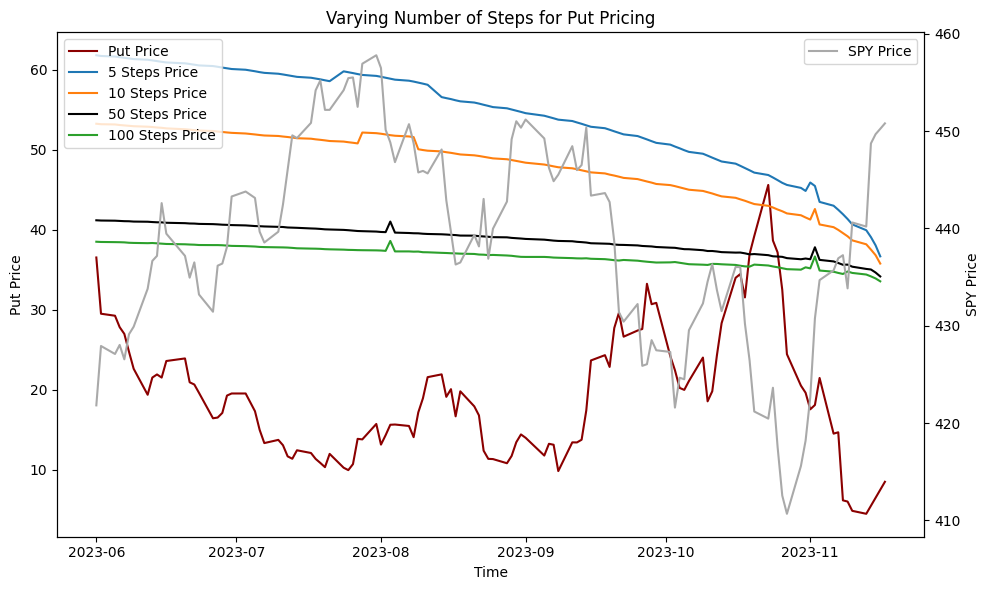

In [2188]:

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Put Price', color='black')
ax1.plot(put['put'], color='darkred', label='Put Price')
ax1.plot(put['5price'], label='5 Steps Price')
ax1.plot(put['10price'], label='10 Steps Price')
ax1.plot(put['50price'], color='black', label='50 Steps Price')
ax1.plot(put['100price'], label='100 Steps Price')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')  
ax2.plot(put['spy'], color='darkgray', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Varying Number of Steps for Put Pricing')
fig.tight_layout()  
plt.show()


### VARYING INTEREST RATES

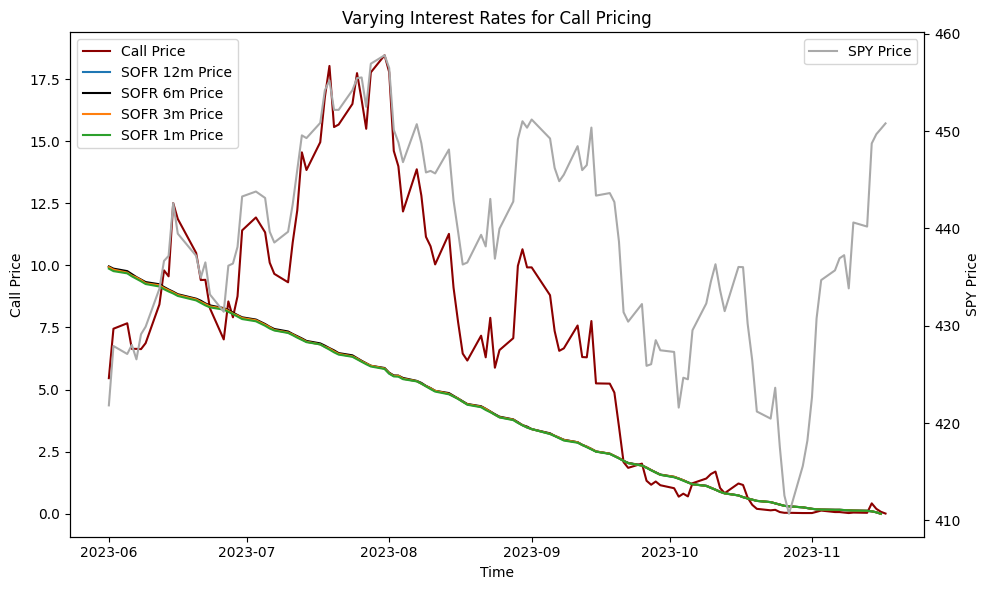

In [2189]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Call Price', color='black')
ax1.plot(call['call'], color='darkred', label='Call Price')
ax1.plot(call['sofr12mprice'], label='SOFR 12m Price')
ax1.plot(call['sofr6mprice'], color='black', label='SOFR 6m Price')
ax1.plot(call['sofr3mprice'], label='SOFR 3m Price')
ax1.plot(call['sofr1mprice'], label='SOFR 1m Price')

ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')
ax2.plot(call['spy'], color='darkgray', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Varying Interest Rates for Call Pricing')
fig.tight_layout()  
plt.show()


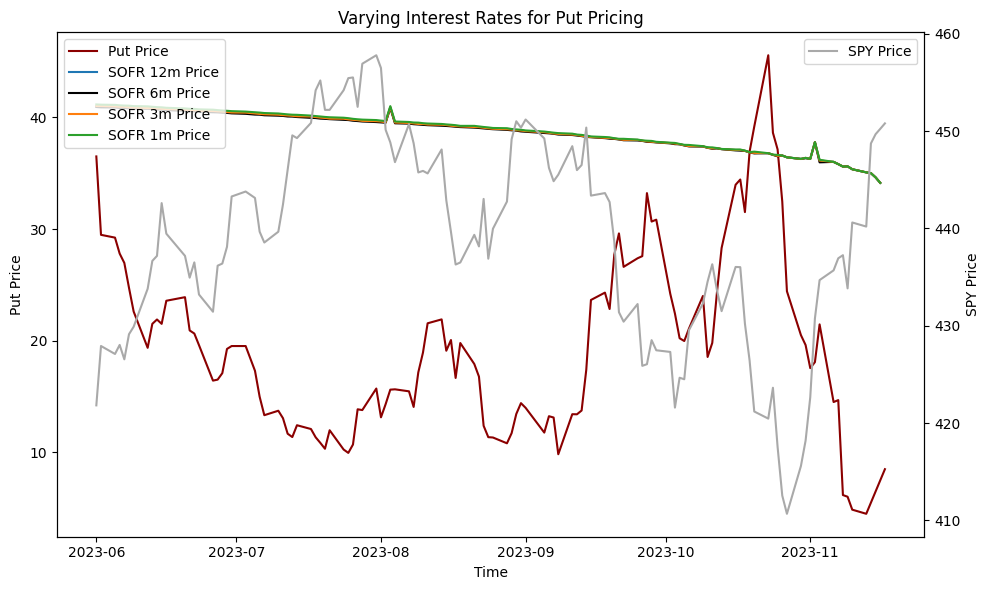

In [2190]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Put Price', color='black')
ax1.plot(put['put'], color='darkred', label='Put Price')
ax1.plot(put['sofr12mprice'], label='SOFR 12m Price')
ax1.plot(put['sofr6mprice'], color='black', label='SOFR 6m Price')
ax1.plot(put['sofr3mprice'], label='SOFR 3m Price')
ax1.plot(put['sofr1mprice'], label='SOFR 1m Price')

ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')  
ax2.plot(put['spy'], color='darkgray', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Varying Interest Rates for Put Pricing')
fig.tight_layout()  
plt.show()


### PLOT VOLS OVER TIME

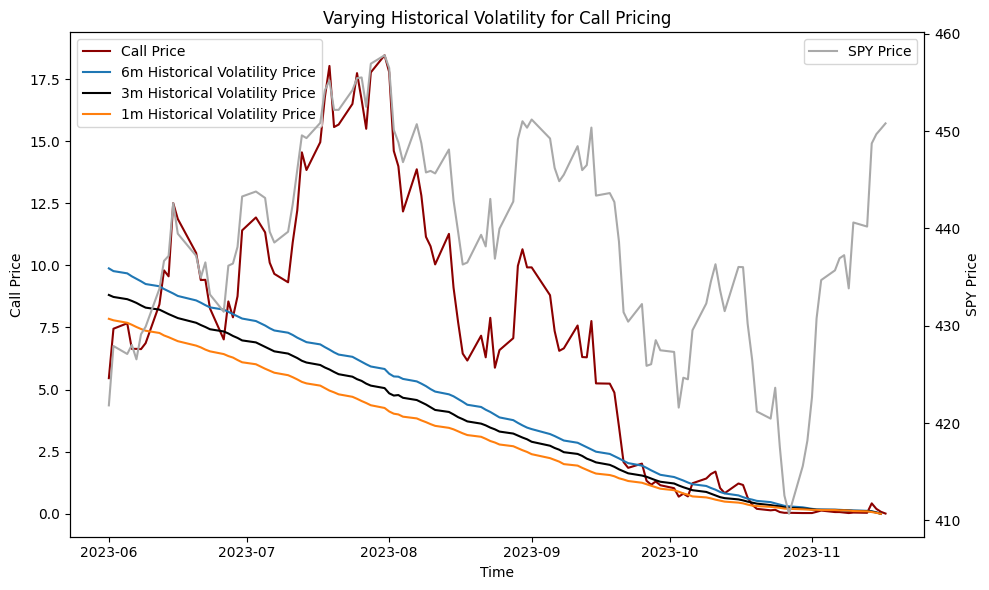

In [2192]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Call Price', color='black')
ax1.plot(call['call'], color='darkred', label='Call Price')
ax1.plot(call['hvol6price'], label='6m Historical Volatility Price')
ax1.plot(call['hvol3price'], color='black', label='3m Historical Volatility Price')
ax1.plot(call['hvol1price'], label='1m Historical Volatility Price')

ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')
ax2.plot(call['spy'], color='darkgray', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Varying Historical Volatility for Call Pricing')
fig.tight_layout()  
plt.show()


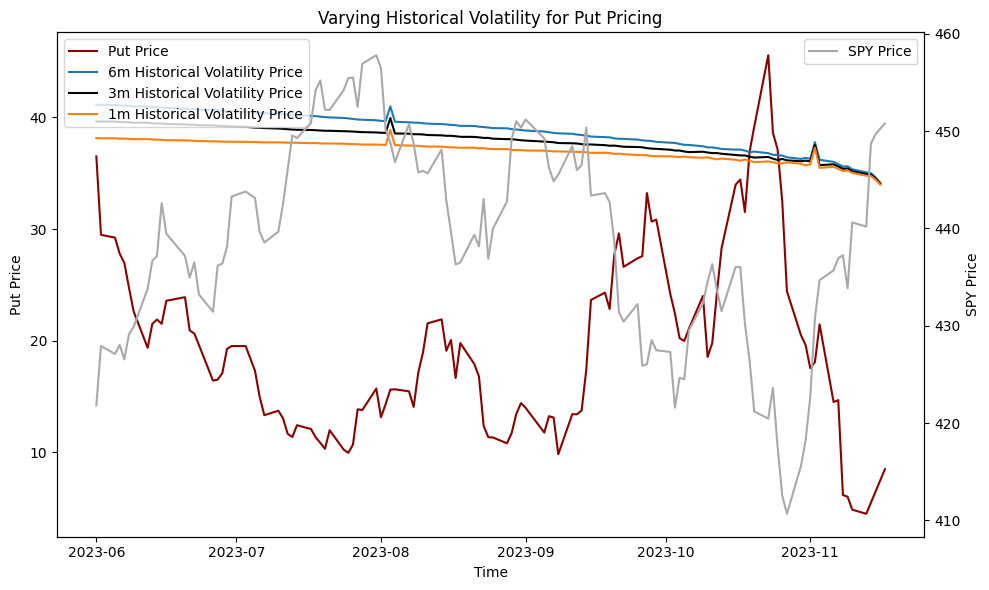

In [2193]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Put Price', color='black')
ax1.plot(put['put'], color='darkred', label='Put Price')
ax1.plot(put['hvol6price'], label='6m Historical Volatility Price')
ax1.plot(put['hvol3price'], color='black', label='3m Historical Volatility Price')
ax1.plot(put['hvol1price'], label='1m Historical Volatility Price')

ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')  
ax2.plot(put['spy'], color='darkgray', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Varying Historical Volatility for Put Pricing')
fig.tight_layout()  
plt.show()


### PLOT ERROR OVER TIME OF BASE

In [ ]:
call['error'] = call['baseprice'] - call['call']
put['error'] = put['baseprice'] - put['put']

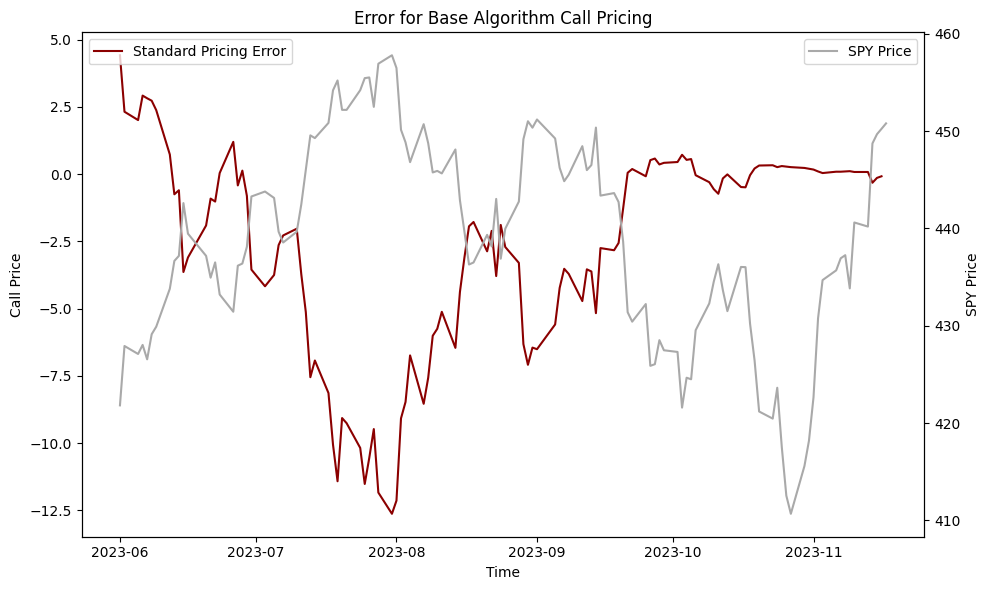

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Call Price', color='black')
ax1.plot(call['error'], color='darkred', label='Standard Pricing Error')


ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')
ax2.plot(call['spy'], color='darkgray', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Error for Base Algorithm Call Pricing')
fig.tight_layout()  
plt.show()

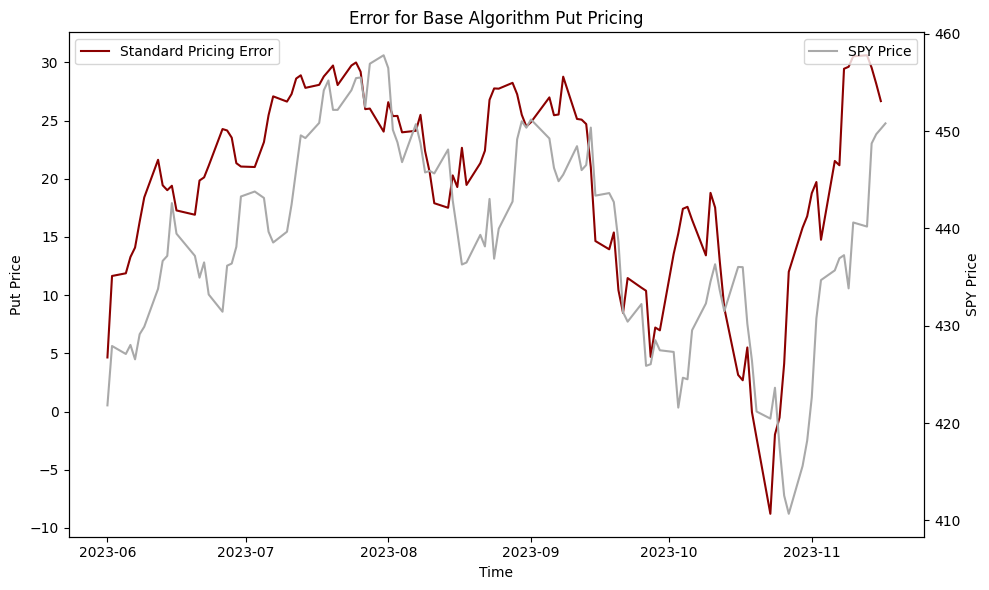

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Put Price', color='black')
ax1.plot(put['error'], color='darkred', label='Standard Pricing Error')


ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price', color='black')
ax2.plot(put['spy'], color='darkgray', label='SPY Price')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Error for Base Algorithm Put Pricing')
fig.tight_layout()  
plt.show()